# Efficient Algorithms for Lasso Regression

The main code for this notebook can be found in the [regression](./regression/__init__.py) package.

In [1]:
%load_ext autoreload
%autoreload 2

import regression
import regression.data  # pyright: ignore[reportUnusedImport]
import regression.optimizer  # pyright: ignore[reportUnusedImport]
import regression.utils  # pyright: ignore[reportUnusedImport]
import regression.models.compressive  # pyright: ignore[reportUnusedImport]

We begin by importing some required modules.

In [2]:
import os
import inspect
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

Our goal is to is to study different algorithms for the Lasso regression problem which is commonly defined as

$$ \min_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2n} \|\mathbf{Xw} - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1 $$

This can be interpreted as a linear regression problem with an additional regularization term promoting sparsity.

In the lecture, we already discussed the non-smoothness due to the $\|\mathbf{w}\|_1$ term, which is non-differentiable. We cannot apply gradient descent directly. Instead, the naive approach involves *subgradient descent*

$$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \frac{\eta}{n} \left( \mathbf{X}^T ( \mathbf{X} \mathbf{w}^{(t)} - \mathbf{y}) + \lambda \cdot \text{sign}(\mathbf{w}^{(t)}) \right) $$

This is implemented in the `regression.SubGradientDescent` class.

In [3]:
print(inspect.getsource(regression.optimizer.SubGradientDescent.step))

    @override
    def step(
        self,
        model: CompressiveLinearModel,
        params: dict[str, np.typing.NDArray[np.float64]],
    ):
        X = params["X"]
        y = params["y"]
        residual = model(X) - y
        grad = X.T @ residual / X.shape[0] + self.lam * np.sign(model.w)
        model.w -= self.learning_rate * grad



We compare this to Proximal Gradient Descent (ISTA) whose updated are defined as

$$ \mathbf{w}^{(t+1)} = \text{prox}_{\eta \lambda} \left( \mathbf{w}^{(t)} - \eta \nabla g(\mathbf{w}^{(t)}) \right) $$

with $g(x) = \frac{1}{2n} \| \mathbf{X} \mathbf{w} - \mathbf{y} \|_2^2$ and the proximal operator defined as

$$ \text{prox}_{\eta \lambda}(z_j) = \text{sign}(z_j) \cdot \max\left( |z_j| - \eta \lambda, \, 0 \right) $$

The advantage lies in the proximal operator, which pushes small values towards zero and promotes sparsity.

The corresponding code is in the `regression.ISTA` class.

In [4]:
print(inspect.getsource(regression.optimizer.ISTA.step))

    @override
    def step(
        self,
        model: CompressiveLinearModel,
        params: dict[str, np.typing.NDArray[np.float64]],
    ):
        X = params["X"]
        y = params["y"]
        grad = X.T @ (X @ model.w - y)

        model.w = prox(
            model.w - self.learning_rate * grad, self.learning_rate * self.lam
        )



## Convergence and Sparsity

Our first goal is to compare the convergence rates of Subgradient Descent and ISTA and compare the sparsity of the resulting solution.

As a synthetic dataset, we consider
$$ \mathbf{y} = \mathbf{X} \mathbf{w}^* + \mathbf{\epsilon} $$
where $\textbf{X}$ is a matrix with gaussian entries and $\mathbf{w}$ is chosen such that $\| \mathbf{w} \|_0 \ll d$

In [5]:
# To ensure reproducibility, we use a seedable RNG
generator = np.random.default_rng(0xDEADBEEF)

In [6]:
(X, y) = regression.data.generate_dataset(60, 100, 10, noise_scale=0.1, generator=generator)

There is no universally accepted measure of sparsity. We take

$$ \| w \|_0 = \# \{ j, w_j \leq\epsilon \} $$

which allows for vectors to only be approximately sparse, i.e. it allows for some noise in the measurement of $w$ to be accepted as sparse. The tradeoff is that this requires $\epsilon$ to be chosen appropriately. 

In [7]:
print(inspect.getsource(regression.utils.sparsity))

def sparsity(vector: np.typing.NDArray[np.float64], epsilon: float = 0.0001) -> float:
    return float(np.less(vector, epsilon).sum())



In [8]:
w_0 = generator.normal(size=[60])
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = regression.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
model_1 = regression.models.compressive.CompressiveLinearModel(w_0)
# model_1 = regression.CompressiveLinearModel(np.zeros([60]))
model_2 = deepcopy(model_1)

In [9]:
lambda_max = np.max(X.T @ y)

In [10]:
def l2(x_1: np.typing.NDArray[np.float64], x_2: np.typing.NDArray[np.float64]):
    return float(np.linalg.norm(x_2 - x_1))

In [11]:
metrics_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_2 = regression.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})

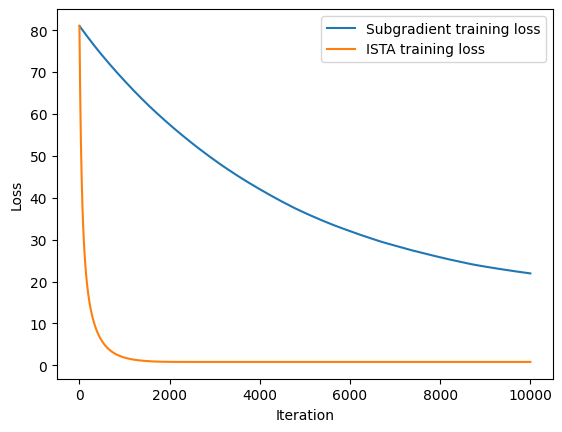

In [12]:
plt.plot(metrics_1["l2"])
plt.plot(metrics_2["l2"])
plt.legend(
    [
        "Subgradient training loss",
        "ISTA training loss",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

This indicated that ISTA results on a much better convergence rate.

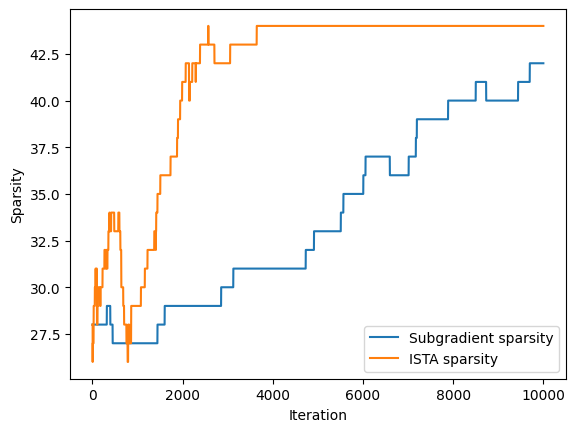

In [13]:
plt.plot(metrics_1["sparsity"])
plt.plot(metrics_2["sparsity"])
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()

Similarly, the ISTA iterates approach higher sparsity in fewer iterations.

In [14]:
print("Subgradient sparsity: ", metrics_1["sparsity"][-1])
print("ISTA sparsity:", metrics_2["sparsity"][-1])

Subgradient sparsity:  42.0
ISTA sparsity: 44.0


We can see that the ISTA iterates get closer to the optimal sparsity of 50.

## Path behavior

We additionally seek to study the path the parameters take during training. Here, we also compare different initialization strategies for $w_0$.

We begin with the case where $w_0$ has normally distributed entries.

In [15]:
w_0 = generator.normal(size=[60])
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = regression.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
model_1 = regression.models.compressive.CompressiveLinearModel(w_0)
# model_1 = regression.CompressiveLinearModel(np.zeros([60]))
model_2 = deepcopy(model_1)

metrics_normal_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_normal_2 = regression.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})

w_0 = np.zeros([60])
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = regression.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
model_1 = regression.models.compressive.CompressiveLinearModel(w_0)
# model_1 = regression.CompressiveLinearModel(np.zeros([60]))
model_2 = deepcopy(model_1)

metrics_zero_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_zero_2 = regression.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})

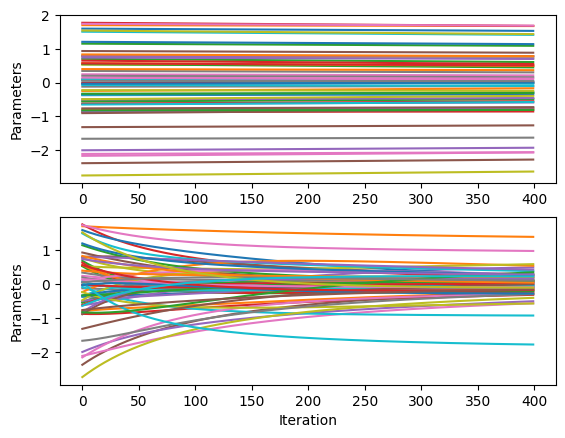

In [16]:
fig, axs = plt.subplots(2)
axs[0].plot(metrics_normal_1["path"][0:400])
axs[0].set_ylabel("Parameters")
axs[1].plot(metrics_normal_2["path"][0:400], label="TEst")
axs[1].set_ylabel("Parameters")

plt.xlabel("Iteration")

plt.show()

In the case of subgradient descent, the parameters uniformly converge to a solution. With ISTA however, the parameters mostly move during the beginning of training, with most tending to values close to 0.

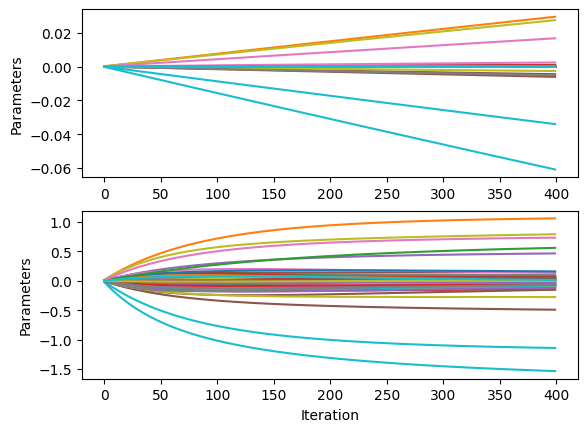

In [17]:
fig, axs = plt.subplots(2)
axs[0].plot(metrics_zero_1["path"][0:400])
axs[0].set_ylabel("Parameters")
axs[1].plot(metrics_zero_2["path"][0:400])
axs[1].set_ylabel("Parameters")

plt.xlabel("Iteration")

plt.show()

With 0 initialization, the subgradient iterated are initially sparse, which promotes sparsity in the final solution.

## Comparison of different lambda

The LASSO problem contains the hyperparameter $\lambda$ which dictated the tradeoff between exact solutions to the linear regression problem and the sparsity of the desired solution.

In [18]:
lambda_max = np.max(X.T @ y)

In [19]:
sub_sparsity = []
ista_sparsity = []

axes = np.linspace(0.0, lambda_max, 300)

for lam in tqdm(axes):
    sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.0001, lam=lam)
    ista = regression.optimizer.ISTA(learning_rate=0.0001, lam=lam)
    model_1 = regression.models.compressive.CompressiveLinearModel(generator.normal(size=[60]))
    model_2 = deepcopy(model_1)
    metrics_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
    metrics_2 = regression.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

    sub_sparsity.append(metrics_1["sparsity"][-1])
    ista_sparsity.append(metrics_2["sparsity"][-1])

  0%|          | 0/300 [00:00<?, ?it/s]

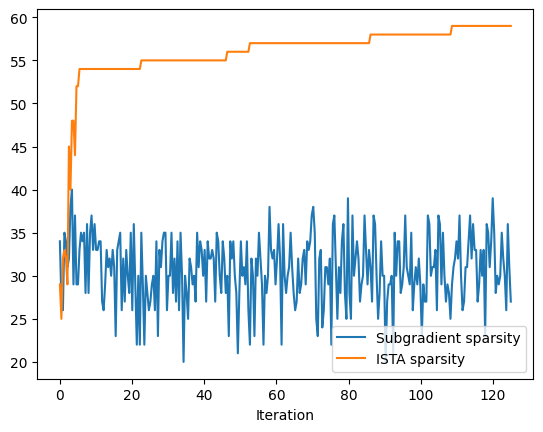

In [20]:
plt.plot(axes, sub_sparsity)
plt.plot(axes, ista_sparsity)
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
    ]
)
plt.xlabel("Iteration")
plt.show()

## Sensitivity to initialization

We analyze the resulting sparsity of the solution based on initialization. In particular, we compare
- Zero initialization
- Normal initialization
- Initialization by the normal equation solution for linear least squares regression

In [21]:
w_0 = np.zeros([60])
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.001)
ista = regression.optimizer.ISTA(learning_rate=0.001)
model_1 = regression.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)
metrics_zeros_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
metrics_zeros_2 = regression.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

w_0 = generator.normal(size=[60])
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.001)
ista = regression.optimizer.ISTA(learning_rate=0.001)
model_1 = regression.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)
metrics_normal_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
metrics_normal_2 = regression.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

w_0 = np.linalg.inv(X.T @ X) @ (X.T @ y)
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.001)
ista = regression.optimizer.ISTA(learning_rate=0.001)
model_1 = regression.models.compressive.CompressiveLinearModel(np.random.normal(size=[60]))
model_2 = deepcopy(model_1)
metrics_least_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
metrics_least_2 = regression.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

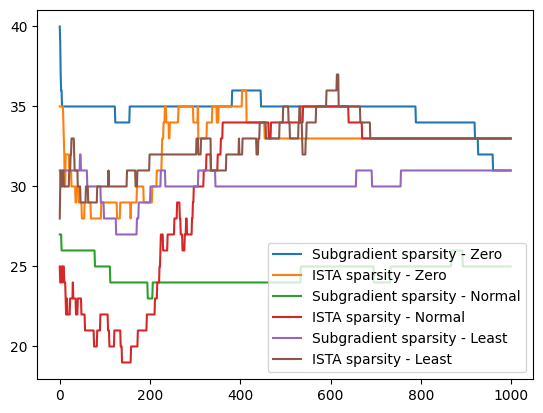

In [22]:
plt.plot(metrics_zeros_1["sparsity"])
plt.plot(metrics_zeros_2["sparsity"])
plt.plot(metrics_normal_1["sparsity"])
plt.plot(metrics_normal_2["sparsity"])
plt.plot(metrics_least_1["sparsity"])
plt.plot(metrics_least_2["sparsity"])
plt.legend(
    [
        "Subgradient sparsity - Zero",
        "ISTA sparsity - Zero",
        "Subgradient sparsity - Normal",
        "ISTA sparsity - Normal",
        "Subgradient sparsity - Least",
        "ISTA sparsity - Least",
    ]
)
plt.show()

## Convergence with learning rate

In our analysis so far, we have chosen the same `learning_rate` for subgradient descent and ISTA. A priori, it is possible that the convergence of subgradient descent highly depends on the `learning_rate` and that more optimal learning rates could outperform ISTA. We therefore compare both algorithms over a range of learning rates.

In [23]:
sub_error = []
ista_error = []

axes = np.linspace(0.0001, 0.006, 300)

for learning_rate in tqdm(axes):
    sub_optim = regression.optimizer.SubGradientDescent(learning_rate=learning_rate)
    ista = regression.optimizer.ISTA(learning_rate=learning_rate)
    model_1 = regression.models.compressive.CompressiveLinearModel(np.random.normal(size=[60]))
    model_2 = deepcopy(model_1)
    metrics_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
    metrics_2 = regression.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

    sub_error.append(metrics_1["l2"][-1])
    ista_error.append(metrics_2["l2"][-1])

  0%|          | 0/300 [00:00<?, ?it/s]

The interval $[0.0001, 0.006]$ was chosen based on stability, since higher learning rates result in numerical instability.

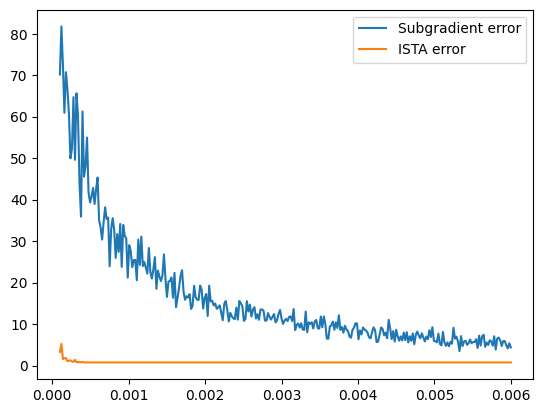

In [24]:
plt.plot(axes, sub_error)
plt.plot(axes, ista_error)
plt.legend(
    [
        "Subgradient error",
        "ISTA error",
    ]
)
plt.show()

While the convergence of subgradient descent depends on the learning rate, it does not outperform ISTA until becoming numerically unstable.

# Boston Housing

So far, we have only used synthetic datasets for our evaluation. We additionally compare subgradient descent and ISTA on the Boston Housing dataset.

In [25]:
file_name = 'boston_housing.csv'
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `boston_housing.csv`...


In [26]:
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [27]:
def normalize(x):
    return (x - np.mean(x, axis=0))/np.std(x,axis=0)

In [28]:
X = normalize(df.iloc[:,df.columns != 'medv'].to_numpy())
y = df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

In [29]:
lam = 0.0001

sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.00001, lam=lam)
ista = regression.optimizer.ISTA(learning_rate=0.00001, lam=lam)
model_1 = regression.models.compressive.CompressiveLinearModel(np.random.normal(size=[X.shape[1]]))
model_2 = deepcopy(model_1)

metrics_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=100, metrics_dict={"l2": l2})
metrics_2 = regression.fit(model_2, ista, X, y, num_epochs=100, metrics_dict={"l2": l2})

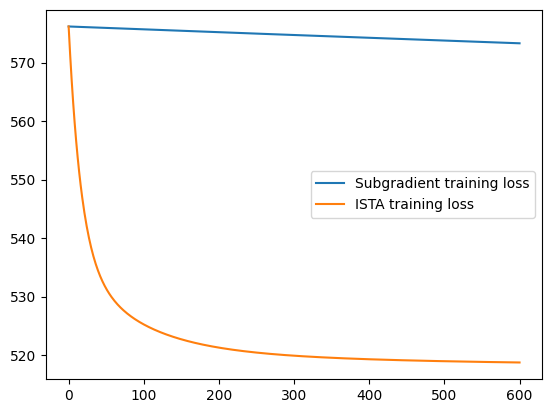

In [30]:
plt.plot(metrics_1["l2"])
plt.plot(metrics_2["l2"])
# plt.yscale("log")
# plt.xscale("log")
plt.legend(
    [
        "Subgradient training loss",
        "ISTA training loss",
    ]
)
plt.show()

# Elastic Net

In [31]:
(X, y) = regression.data.generate_dataset(60, 100, 10, noise_scale=0.1, generator=generator)

w_0 = generator.normal(size=[60])
sub_optim = regression.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = regression.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
elastic = regression.optimizer.ElasticNet(learning_rate=0.0001, lam_1=0.5, lam_2=0.5)
model_1 = regression.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)
model_3 = deepcopy(model_1)

metrics_1 = regression.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_2 = regression.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_3 = regression.fit(model_3, elastic, X, y, num_epochs=10000, metrics_dict={"l2": l2})

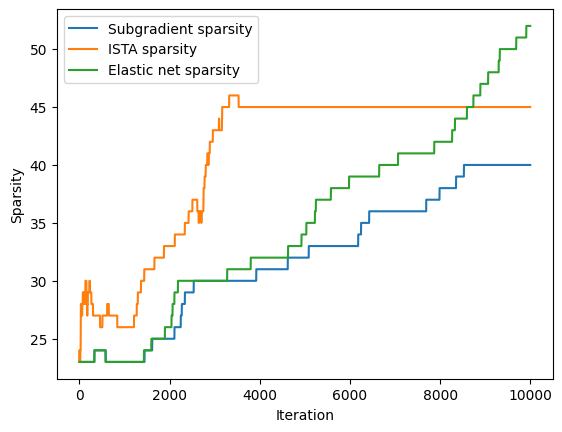

In [32]:
plt.plot(metrics_1["sparsity"])
plt.plot(metrics_2["sparsity"])
plt.plot(metrics_3["sparsity"])
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
        "Elastic net sparsity",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()